In [1]:
import os, sys
import numpy as np

sys.path.append('/mnt/home/sbelkner/git/pySHT/build')
import popy

In [2]:
thetas = np.linspace(0, np.pi, 100, dtype=np.double)
phi0 = np.zeros(100)
nphis = np.ones(100, dtype=int)*100
ringstarts = np.arange(0, 10000, 100, dtype=int)
red = np.random.rand(10000).astype(np.double)
imd = np.random.rand(10000).astype(np.double)
nrings = 100
npix = 10000
output_array = np.zeros(10000, dtype=np.double)

pp = popy.Cpointing(thetas, phi0, nphis, ringstarts, red, imd, nrings, npix, output_array)

: 

In [6]:
pp.__dict__

AttributeError: 'NoneType' object has no attribute '__dict__'

In [9]:
import os
import numpy as np
os.environ['LD_LIBRARY_PATH']="/mnt/sw/nix/store/zi2wc26znf75csf5hhz77p0d2bbz53ih-cuda-11.8.0/lib64:$LD_LIBRARY_PATH"
from pycuda import gpuarray
import pycuda.driver as cuda
cuda.init() 

In [10]:
gpuarray.empty((100,10),dtype=np.complex128)

LogicError: cuMemAlloc failed: invalid device context

In [1]:
from pycuda import gpuarray
import shtns
lmax, mmax = 100, 100
constructor = shtns.sht(int(lmax), int(mmax))
constructor.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS)
alm = gpuarray.zeros(constructor.nlm, dtype=complex)   # or get a conforming cupy array from somewhere else
x = gpuarray.empty((constructor.nphi, constructor.nlat))   # theta contiguous, array that will hold the result
constructor.cu_SH_to_spat(alm, x)  # will fill x with the spatial data synthesized from alm

[SHTns 3.6.6] built Apr  1 2024, 12:43:07, id: v3.6.6-1-ga469229*,avx512,ishioka,openmp


LogicError: cuMemAlloc failed: initialization error

In [13]:
import numpy as np
import time
import cupy as cp
import shtns

lmax, mmax = 2048-1, 2048-1
_ = shtns.sht(int(lmax), int(mmax))
_.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS)
_.print_info()
alm_random = np.random.randn(_.nlm).astype(complex)
alm = cp.array(alm_random, dtype=complex)


start = time.time()
cp.cuda.runtime.deviceSynchronize()
buff = _.synth_grad(alm_random)
cp.cuda.runtime.deviceSynchronize()
stop = time.time()
ret = np.array([a.flatten() for a in buff])
print("synth_grad:: time elapsed: ", stop-start)


constructor = shtns.sht(int(lmax), int(mmax))
constructor.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS, nlat=(lmax+1), nphi=2*(lmax+1))
alm_random = np.random.randn(constructor.nlm).astype(complex)
alm = cp.array(alm_random, dtype=complex)
x = cp.empty((constructor.nphi, constructor.nlat), dtype=np.double)

print(alm.shape, x.shape)
start = time.time()
cp.cuda.runtime.deviceSynchronize()
constructor.cu_SH_to_spat(alm.data.ptr, x.data.ptr)
cp.cuda.runtime.deviceSynchronize()
stop = time.time()
print(x)
print("cu_SH_to_spat:: time elapsed: ", stop-start) 

  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
Lmax=2047, Mmax*Mres=2047, Mres=1, Nlm=2098176  [10 threads, gpu fp64/fp64, orthonormalized]
Gauss grid : Nlat=2048, Nphi=4096, Nbatch=1
        syn   ana   vsy   van   gsp   gto   v3s   v3a 
   std: gpu1  gpu1  gpu1  gpu1  gpu1  gpu1  gpu1  gpu1 
     m: fly2  fly2  fly2  fly2  fly2  fly2  fly2  fly2 
gpu cfg: fp64/fp64
synth_grad:: time elapsed:  0.057914018630981445
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
(2098176,) (4096, 2048)
[[    2.66252997  -747.91439822 -1095.8169068  ...   390.2223958
   -261.50680989  1837.18576676]
 [    2.66184598  -747.91260128 -1095.78740516 ...   390.20214557
   -261.50109031  1837.18400258]
 [ 

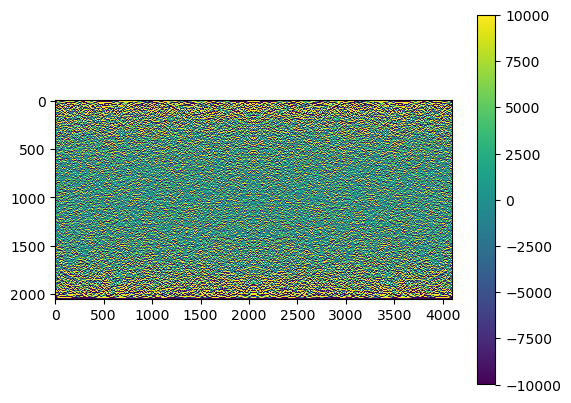

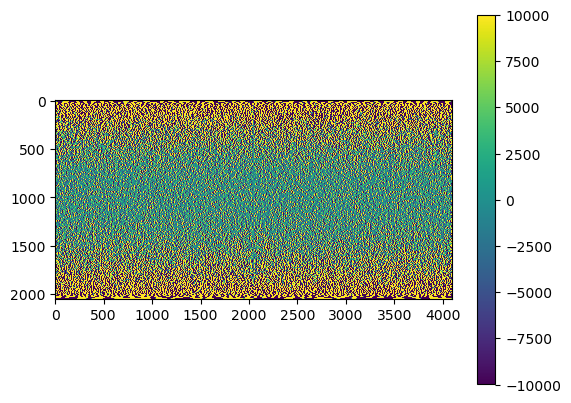

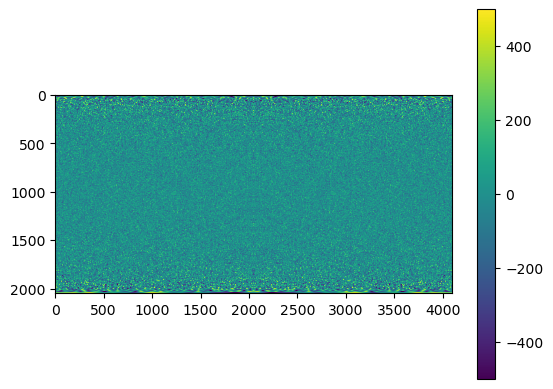

In [21]:
plt.imshow(x.get().T, vmin=-5e2, vmax=5e2)
plt.colorbar()

In [1]:
import numpy as np
import time
import cupy as cp
import shtns

lmax, mmax = 2048-1, 2048-1
_ = shtns.sht(int(lmax), int(mmax))
_.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS)
# _.print_info()
alm_random = np.random.randn(_.nlm) + 1j*np.random.randn(_.nlm)
alm = cp.array(alm_random)
print(_.nlat, _.nphi, _.nlm)
out_theta = cp.empty(shape=_.nlat*_.nphi, dtype=np.double)
out_phi = cp.empty(shape=_.nlat*_.nphi, dtype=np.double)

print(alm.shape, out_theta.shape, out_phi.shape)

start = time.time()
# cp.cuda.runtime.deviceSynchronize()
_.cu_SHsph_to_spat(alm.data.ptr, out_theta.data.ptr, out_phi.data.ptr)
# cp.cuda.runtime.deviceSynchronize()
stop = time.time()
print("synth_grad:: time elapsed: ", stop-start)

[SHTns 3.6.6] built Apr  4 2024, 19:17:02, id: v3.6.6-6-gd00ef3e*,avx512,ishioka,openmp,cuda
  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
2048 4096 2098176
(2098176,) (8388608,) (8388608,)
synth_grad:: time elapsed:  0.00011944770812988281


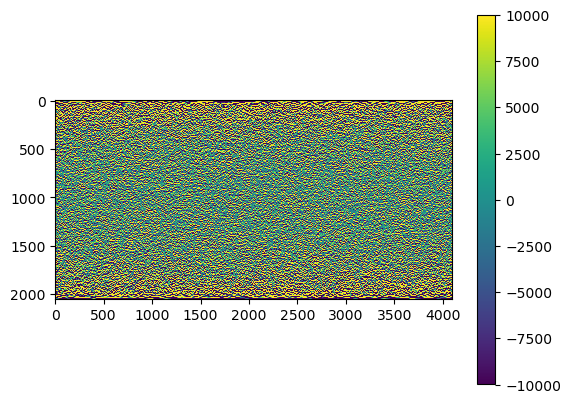

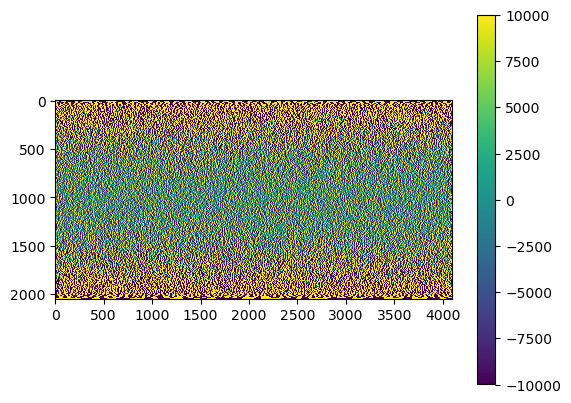

In [12]:
import matplotlib.pyplot as plt

plt.imshow(out_theta.get().reshape(2*lmax+2, -1).T, vmin=-1e4, vmax=1e4)
plt.colorbar()
plt.show()

plt.imshow(out_phi.get().reshape(2*lmax+2, -1).T, vmin=-1e4, vmax=1e4)
plt.colorbar()

plt.show()

In [9]:
2098176/2049

1024.0

In [ ]:
import numpy as np
import time
import cupy as cp
import shtns

lmax, mmax = 2048-1, 2048-1

constructor = shtns.sht(int(lmax), int(mmax))
constructor.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS, nlat=(lmax+1), nphi=2*(lmax+1))
alm_random = np.random.randn(constructor.nlm).astype(complex)
alm = cp.array(alm_random, dtype=complex)
x = cp.empty((constructor.nphi, constructor.nlat), dtype=np.double)

print(alm.shape, x.shape)
start = time.time()
cp.cuda.runtime.deviceSynchronize()
constructor.cu_SH_to_spat(alm.data.ptr, x.data.ptr)
cp.cuda.runtime.deviceSynchronize()
stop = time.time()
print(x)
print("cu_SH_to_spat:: time elapsed: ", stop-start) 